In [1]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import distinct

In [4]:
# create engine to hawaii.sqlite (BZ had to add Resources/)
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
# Assign the measurement class to a variable called `Measurement`
# Assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station
print(f'Measurement: {Measurement}')
print(f'Station: {Station}')

Measurement: <class 'sqlalchemy.ext.automap.measurement'>
Station: <class 'sqlalchemy.ext.automap.station'>


In [8]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)

In [9]:
# Display the row's columns and data in dictionary format
# Used Lesson plan 10.2.5 (solved solution) as my reference for what is meant by "Display the row's columns and data in dictionary format"  

# Use the session to query the Measurement table and display the row's columns and data in dictionary format
M=Measurement
Measurement_row = session.query(M).first()
print(f"Display the Measurements first row's columns and data in dictionary format: {Measurement_row.__dict__}")
print()

# Close Session
session.close()
# for row in session.query(M.date, M.tobs, M.id, M.station, M.prcp).all():
#     print(row)
# print()
# print()

# Use the session to query the Stations table and display the row's columns and data in dictionary format
S=Station
Station_row = session.query(S).first()

# Close Session
session.close()

print(f"Display the Stations first row's columns and data in dictionary format: {Station_row.__dict__}")
print()
# for row in session.query(S.id, S.longitude, S.latitude, S.station, S.name, S.elevation).all():
#     print(row)

Display the Measurements first row's columns and data in dictionary format: {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000294F8218760>, 'prcp': 0.08, 'id': 1, 'station': 'USC00519397', 'date': '2010-01-01', 'tobs': 65.0}

Display the Stations first row's columns and data in dictionary format: {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000294F8204610>, 'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'id': 1, 'latitude': 21.2716, 'elevation': 3.0}



# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Found Lesson 10.2.9 helpful for this part (09-Par_EmojiPlotting)

results = session.query(M.date, M.tobs, M.id, M.station, M.prcp).\
    order_by(M.date.desc()).all()
# print(f'results: {results}')

# Close Session
session.close()

max_date = [result[0] for result in results[:1]]
print(f'Most recent date in the data set (maximum_date): {max_date[0:1][0]}')

# Calculate the date one year from the last date in data set.
min_date = dt.date(int(max_date[0][0:4]), int(max_date[0][5:7]), int(max_date[0][8:10]))  - relativedelta(months=12)

print(f'Date for 12 months prior (minimun_date): {min_date}')
print()


Most recent date in the data set (maximum_date): 2017-08-23
Date for 12 months prior (minimun_date): 2016-08-23



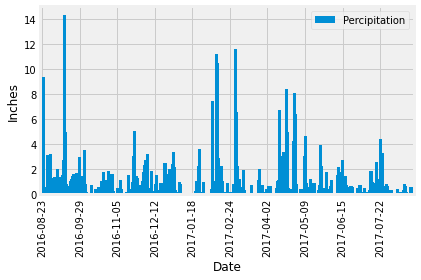

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(M.date, func.sum(M.prcp)).\
     group_by(M.date).\
     filter(M.date >= min_date).all()

date = [date_prcp[0] for date_prcp in date_prcp]
prcp = [date_prcp[1] for date_prcp in date_prcp]

# print(f'date_prcp: {date_prcp}')
# print()

# Close Session
session.close()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(date_prcp, columns=['Date', 'Percipitation'])
# print(f'df:{df}')
# print()
df.set_index('Date', inplace=True)


# Sort the dataframe by date
df.sort_values(by='Date', ascending=False)
    

# Determine the tick marks needed for the plot 
date_ticks=[]
tick_locations=[]
i = 0
# print(len(df))
while i < len(df):
    # print(f'df.index[i]: {df.index[i]}')
    #print(df[i:i+1][0:1])
    date_ticks.append(df.index[i])
    tick_locations.append(i)
    i = i + 37


# Set labels, tick locations and show plot
x_axis = np.arange(0, len(df))


df.plot.bar(width = 3) 
plt.xlabel("Date", fontdict=None, labelpad=None)
plt.ylabel("Inches", fontdict=None, labelpad=None)
plt.tight_layout()
plt.xticks(np.arange(0, len(df), 37))
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe(include='all')


,Percipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset

# Create our session (link) from Python to the DB
session = Session(engine)

# Close Session
session.close()

M=Measurement
distinct_stations = session.query(func.count(distinct(M.station))).all()
print(f'Total number of stations in the dataset: {distinct_stations[0][0]}')
print()

Total number of stations in the dataset: 9



In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# Found Lesson 10.3.11 (Stu_Chinook) helpful for this part 
active_stations = session.query(M.station, func.count(M.prcp)).\
     group_by(M.station).\
     order_by(func.count(M.prcp).desc()).all()

# Close Session
session.close()

# print(f'active_stations: {active_stations}')
most_active = active_stations[0][0]
print(f'Most active station: {most_active}')
print()


station = [active_stations[0] for active_stations in active_stations]
counts = [active_stations[1] for active_stations in active_stations]

# Save the query results as a Pandas DataFrame and set the index to the date column
station_counts_df = pd.DataFrame(active_stations, columns=['Station', 'Counts'])
station_counts_df

Most active station: USC00519281



,Station,Counts
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

print(f'Most active station: {most_active}')
print()


max_date = [result[0] for result in results[:1]]
print(f'max_date: {max_date[0:1]}')

# Calculate the date one year from the last date in data set.
min_date = dt.date(int(max_date[0][0:4]), int(max_date[0][5:7]), int(max_date[0][8:10])) - dt.timedelta(days=365)
print("Minimun Date: ", min_date)
print()

Most active station: USC00519281

max_date: ['2017-08-23']
Minimun Date:  2016-08-23



Most active station: USC00519281

Maximun Date:  2017-08-23
Minimun Date:  2016-08-23



Text(0.5, 0, 'Temperature')

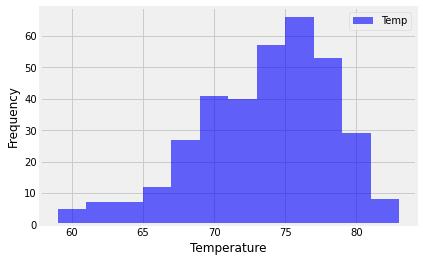

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(f'Most active station: {most_active}')
print()

print("Maximun Date: ", max_date[0:1][0])
print("Minimun Date: ", min_date)
print()

# sel = [M.date, 
#        func.min(M.tobs), 
#        func.max(M.tobs),
#        func.avg(M.tobs)]
# min_max_avg = session.query(*sel).\
#     filter(M.date >= min_date).\
#     group_by(M.date).\
#     order_by((M.date).desc()).all()

# # Close Session
# session.close()  

# print(f'min_max_avg: {min_max_avg}')
# print()

tobs_results = session.query(M.date,M.tobs).\
    filter(M.station == most_active).\
    filter(M.date >= min_date).\
    order_by(M.date.desc()).all()

# Close Session
session.close()

# print(f'tobs_results: {tobs_results}')
# print()

df = pd.DataFrame(tobs_results, columns=['Date', 'Temp'])
#df.set_index('Date', inplace=True)
# print(f'df: {df}')
# print()

# Plot Histogram
df.plot.hist(by= 'Date', bins=12, color="blue", alpha=0.6)
plt.xlabel("Temperature")


In [17]:
# Close Session (this last one per starter.ipynb)
session.close()